# สร้างข้อมูล sounding จาก ERA5 hourly 
* เนื่องจากวันที่เกิดเหตุการณ์พายุลูกเห็บที่เชียงของ ไม่มีข้อมูลตรวจอกาาศช้นบน จากสถานีเชียงใหม่ จึงต้องใช้ข้อมูลจากแบบจำลอง era 5 hourly โดยดูวิธีการและโค้ดจาก https://www.youtube.com/watch?v=C3YwOG8btMk เพื่อที่จะนำไปพลอตใน sharppy
* เชียงรายไม่มีการตรวจวัดสภาพอากาศชั้นบน มีแต่เชียงใหม่ แต่ก็ไม่ได้มีทุกวัน ให้ดูรายชื่อรหัสสถานีตรวจอากาศจากรายงาน wmo ได้ที่ลิงก์  https://library.wmo.int/doc_num.php?explnum_id=9896
* พิกัดภูมิศาสตร์ใช้บริเวณหาดไคร้ ต.เวียง อ.เชียงของ จังหวัดเชียงราย ได้มาจากกุเกิ้ล https://www.google.com/maps/place/Chiang+Khong+District,+Chiang+Rai/@20.2561247,100.4107162,2644m/data=!3m1!1e3!4m5!3m4!1s0x30d6372562c471b5:0x30346c5fa8a7370!8m2!3d20.1651266!4d100.3947116
* ลงโปรแกรม sharppy binary https://github.com/skovic/SHARPpy/releases/tag/v1.4.0-fixed
* ข้อมูล ERA5 hourly https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview


## ดาวน์โหลดข้อมูล era5 hourly วันที่ 23/04/2020 เวลา 0000UTC
* เนื่องจากอยากวิเคราะห์เวลา 1800 Local time เมื่อ - 7UTC เท่ากับ 1100 เท่ากับวันที่ 23 เมษายน 2020 เวลา 11 UTC
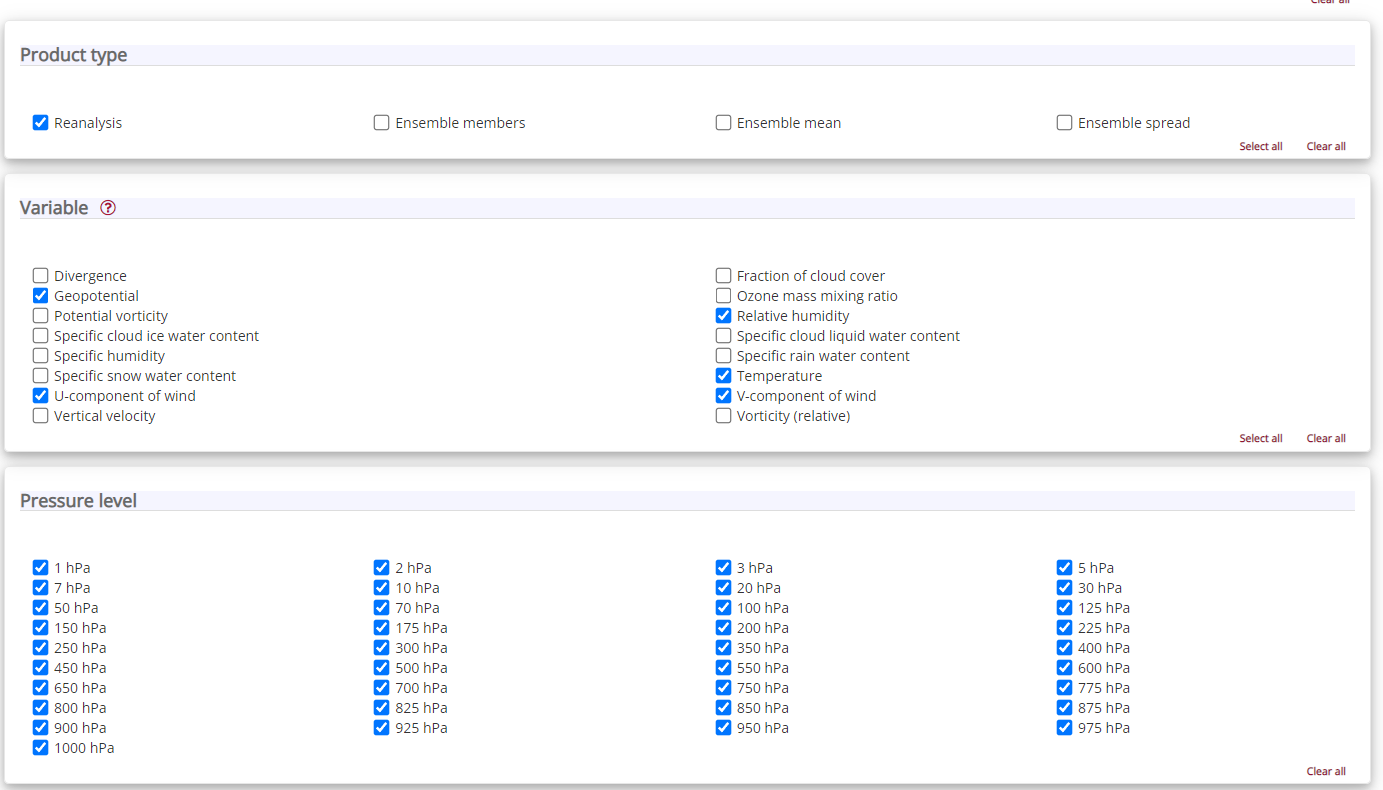

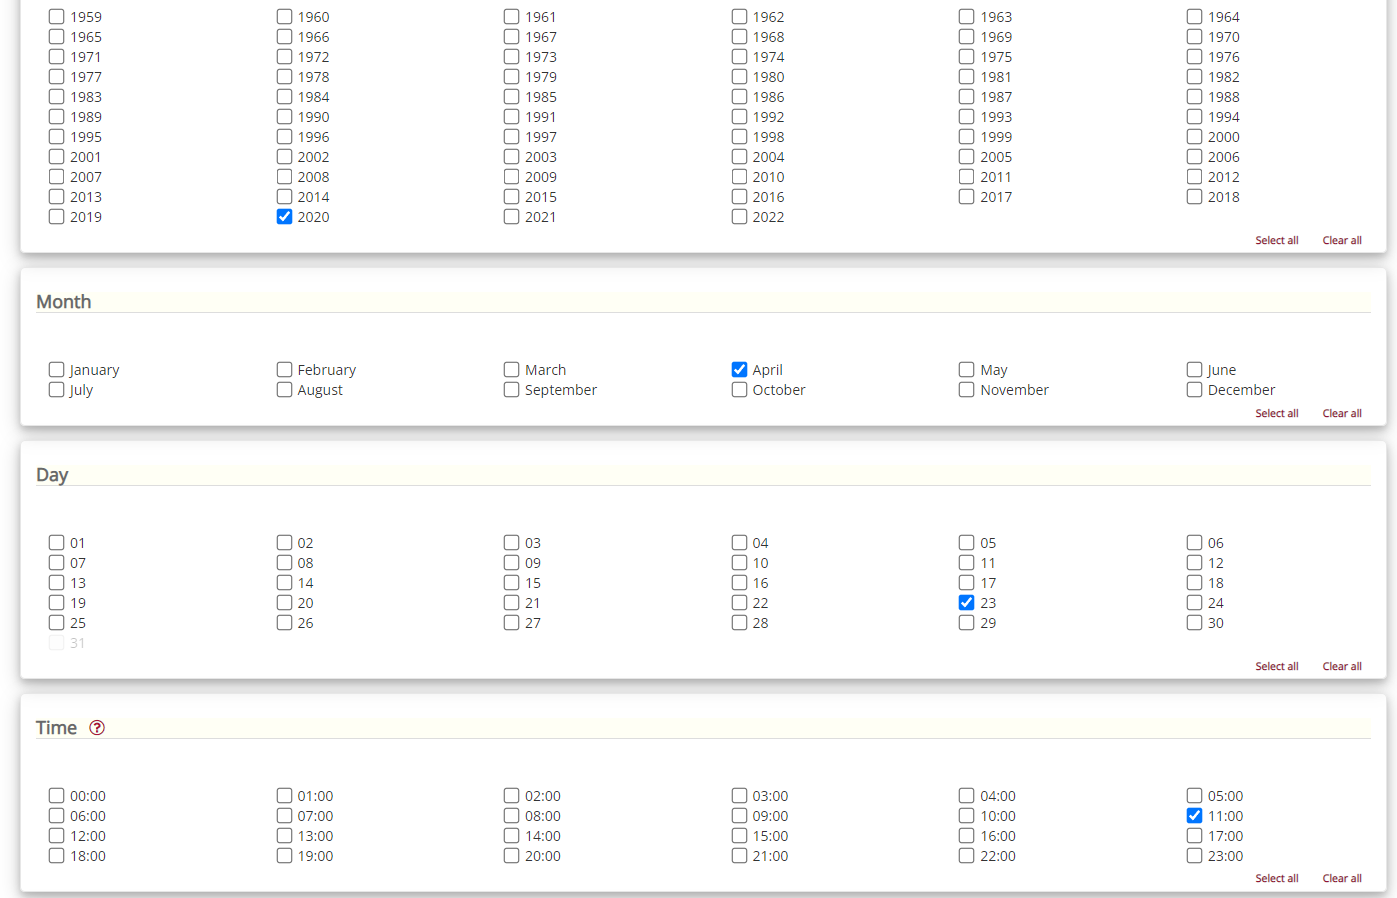

* ใช้ค่าพิกัดต.เวียง อ.เชียงของ จ.เชียงราย  ที่ได้จากกุเกิ้ล
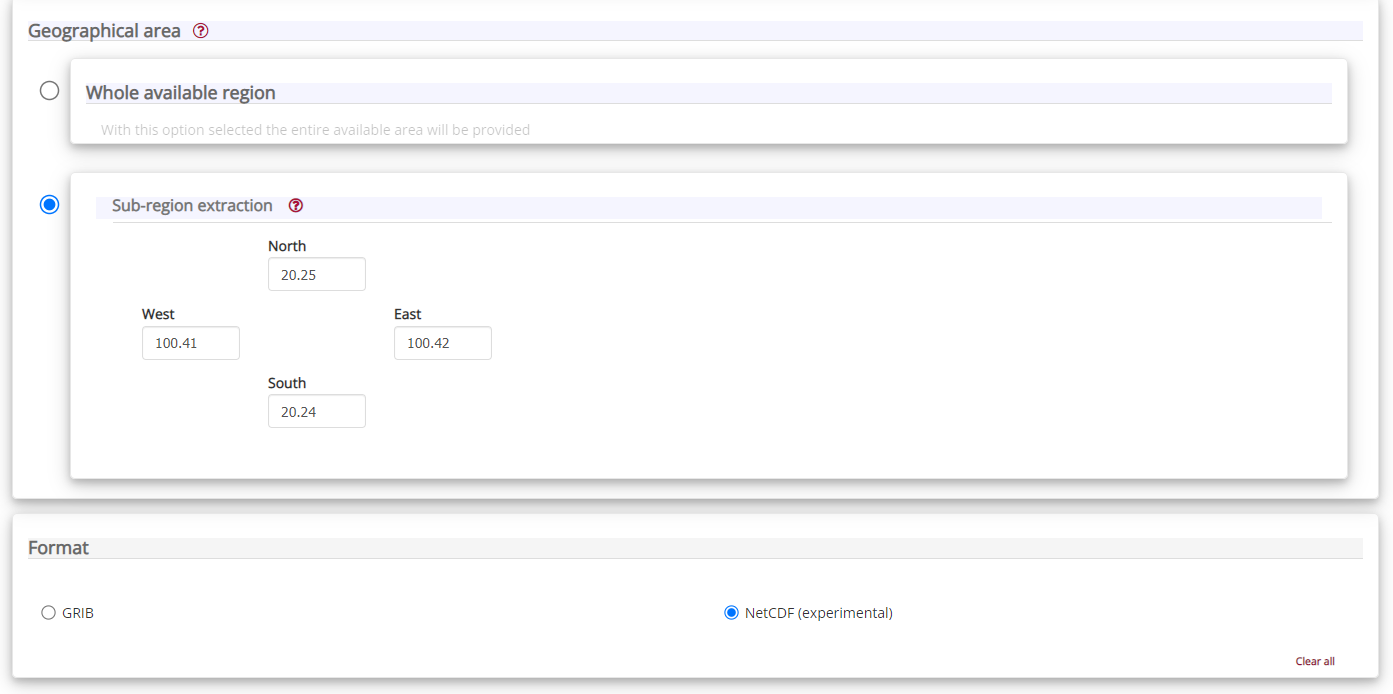


## โค้ดสกัดค่า reanalysis ตามพิกัดที่ต้องการ

In [1]:
from netCDF4 import Dataset
from metpy import calc
from metpy.units import units
import numpy as np

## อ่านค่าแบบจำลองที่สกัดมาได้

In [2]:
ds = Dataset('./1data/chiangkong_23042020_00UTC.nc')
lat = ds['latitude'][:]
lon = ds['longitude'][:]

## หาตำแหน่งที่ใกล้กับตำแหน่งที่ต้องการของหาดไคร้

In [3]:
c_x, c_y = 20.255734, 100.410341
x, y = np.abs(lat - c_x).argmin(), np.abs(lon + c_y).argmin()

## คำนวณค่าตัวแปรอุตุ

In [4]:
levels = ds['level'][:]
z = ds['z'][0, :, y, x] / 9.81
u = ds['u'][0, :, y, x]
v = ds['v'][0, :, y, x]
temp = ds['t'][0, :, y, x] - 273.15
rh = ds['r'][0, :, y, x]

## คำนวณทิศและความเร็วลม อุณหภูมิจุดน้ำค้าง

In [5]:
wdir = np.degrees(np.arctan2(u ,v)) + 180
dew = np.asarray(calc.dewpoint_from_relative_humidity(np.asarray(temp) * units.degC, np.asarray(rh) * units.percent))
wspd = np.hypot(u, v) * 1.944

## บันทึกไฟล์

In [6]:
with open('./2output/era5_23042020n_0000utc.txt', 'w', encoding = 'utf-8') as f:
    f.write(f"%TITLE%\nERA5   {str(2020)[2:]}{str(4).zfill(2)}{str(23).zfill(1)}/{str(2).zfill(11)}00\n-------------------------------------------------------------------\n%RAW%\n")

    for i in reversed(range(len(levels))):
        f.write(f'{levels[i]}, {z[i]},  {temp[i]}, {dew[i]}, {wdir[i]}, {wspd[i]}\n')

    f.write('%END%')
    

## ข้อมูลจากไฟล์  'era5_23042020n_0000utc.txt' ' 
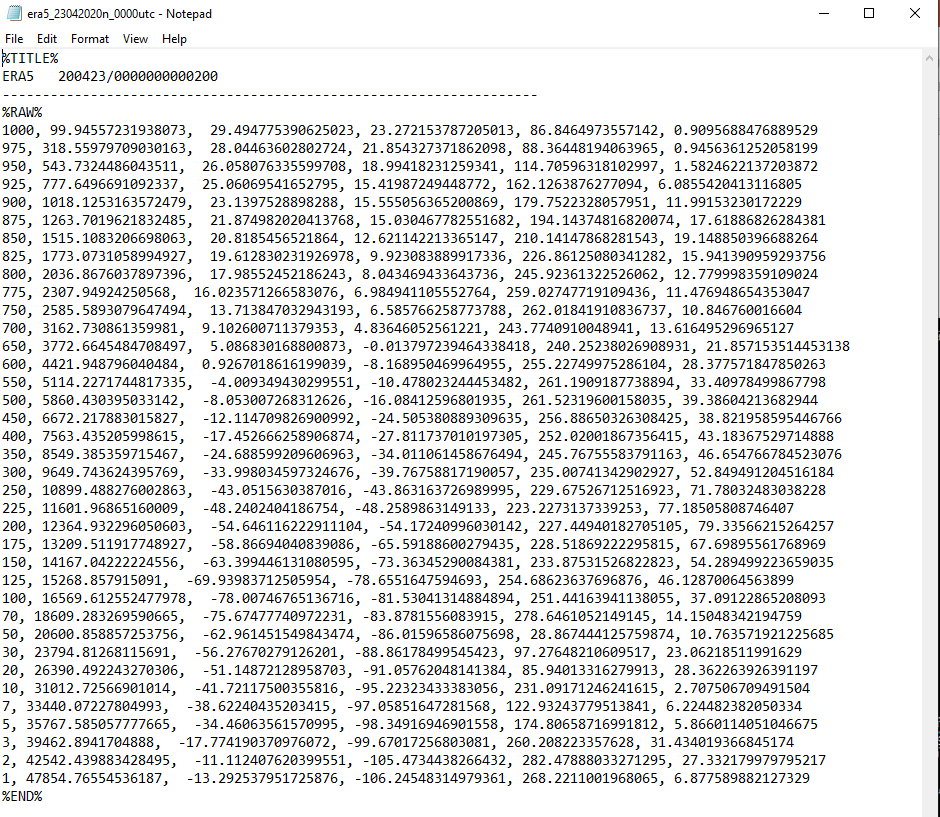

## ต่อไปจะนำไฟล์ 'era5.txt ' ไปเปิดด้วย sharppy

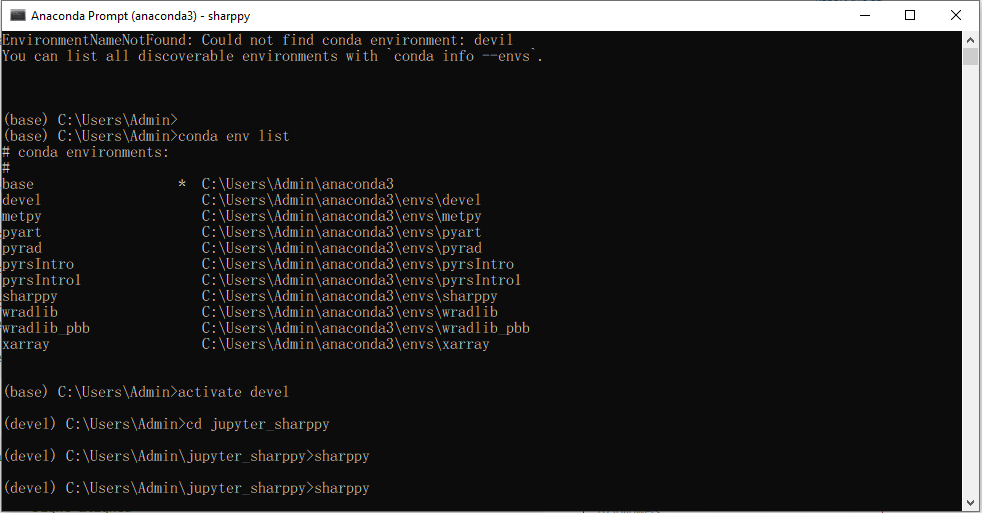

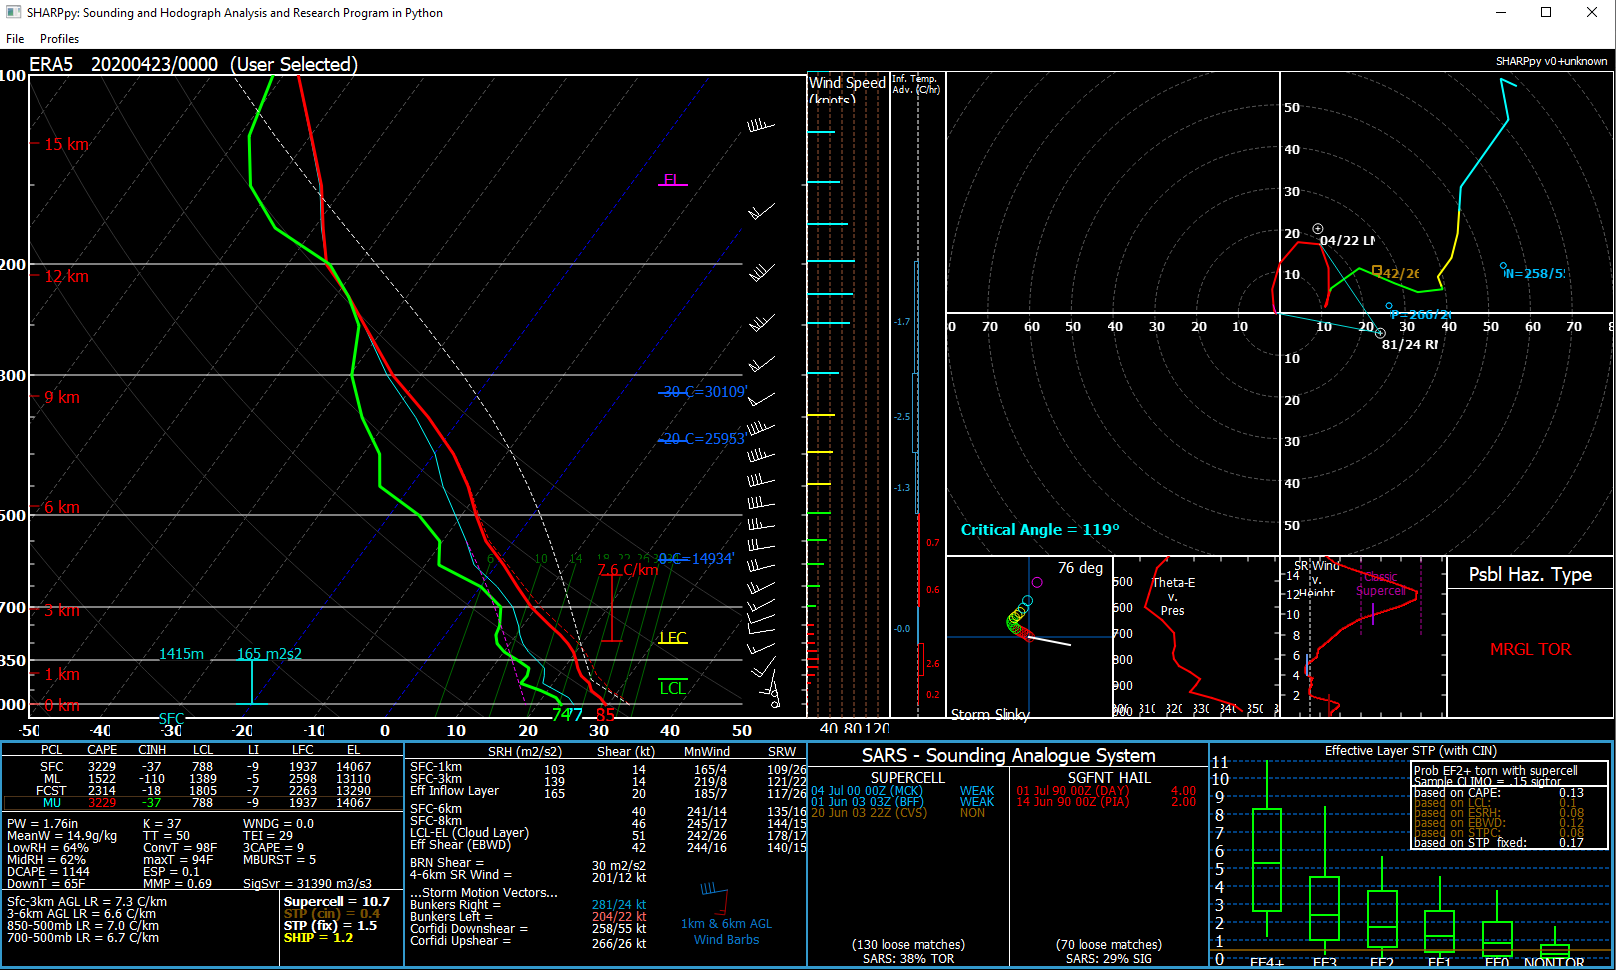

## วิเคราะห์
* สังเกตุค่า CAPE สูงในทุกระดับ ที่ระดับ SFC ผิวพื้นมีค่า CAPE ถึง 5061 J/kg
* ในขณะที่ค่าลมเฉือนยังมีค่าที่ไม่สูงมากนักเมื่อเทียบกับ tornado case https://www.youtube.com/watch?v=lE5j7BoDjpQ
* ค่าลมเฉือนที่วิเคราะห์ด้วย Hodograph แสดงให้เห็นความรุนแรงของลมเฉือนที่วิ่งผ่านเส้นแนวรัศมีของ Hodograph อ่านเอกสารเรื่องลมเฉือน https://www.weather.gov/media/lmk/soo/Hodographs_Wind-Shear.pdf


## สิ่งที่ควรทำต่อไป
* ทำการวิเคราะห์ค่า Thermodynamics แต่ละตัวแปร ในแต่ละช่วงเวลา เพื่อดูแนวโน้มของการเคลื่อนตัว แสดงในรูปของกราฟ
* พลอตค่า SkewT ในแต่ละวันก่อนหน้าสัก 5 วัน ช่วงเวลาบ่าย ๆ เพื่อเปรียบเทียบดูความรุนแรงของวันที่เกิดเหตุ
* ทำการแปลงค่า era 5 ไปเป็น sounding เพื่อนำไปใช้ในการจำแนก MESH โดยใช้ฟอร์แมทของ wyoming ดังมีคอลัมน์ตัวแปรดังต่อไปนี้ ลิงก์ https://weather.uwyo.edu/upperair/columns.html
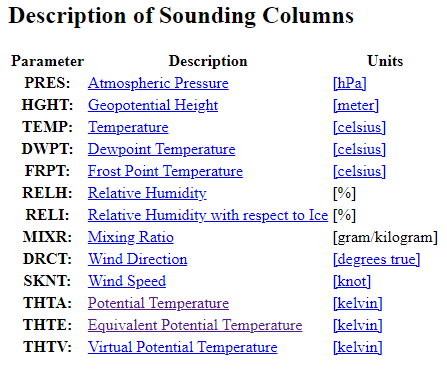

    * 1. ดัดแปลงโค้ดด้านบนในการคำนวนค่าคอลัมน์ THTA, THTE, THTV หรืออาจทำการดาวน์โหลดจาก era 5 โดยตรงมาเลย แล้วนำมา write ให้เป็นฟอร์แมทของ wyoming
    * 2. ในขั้นแรก อาจต้องนำฟอร์แมท wyoming มาแกะ เปิดใน Notepad ++  หรือ Excel แล้วทำการแทนที่ค่าของเราที่ได้จาก era5  เพื่อนำไปทดสอบโค้ดก่อน
    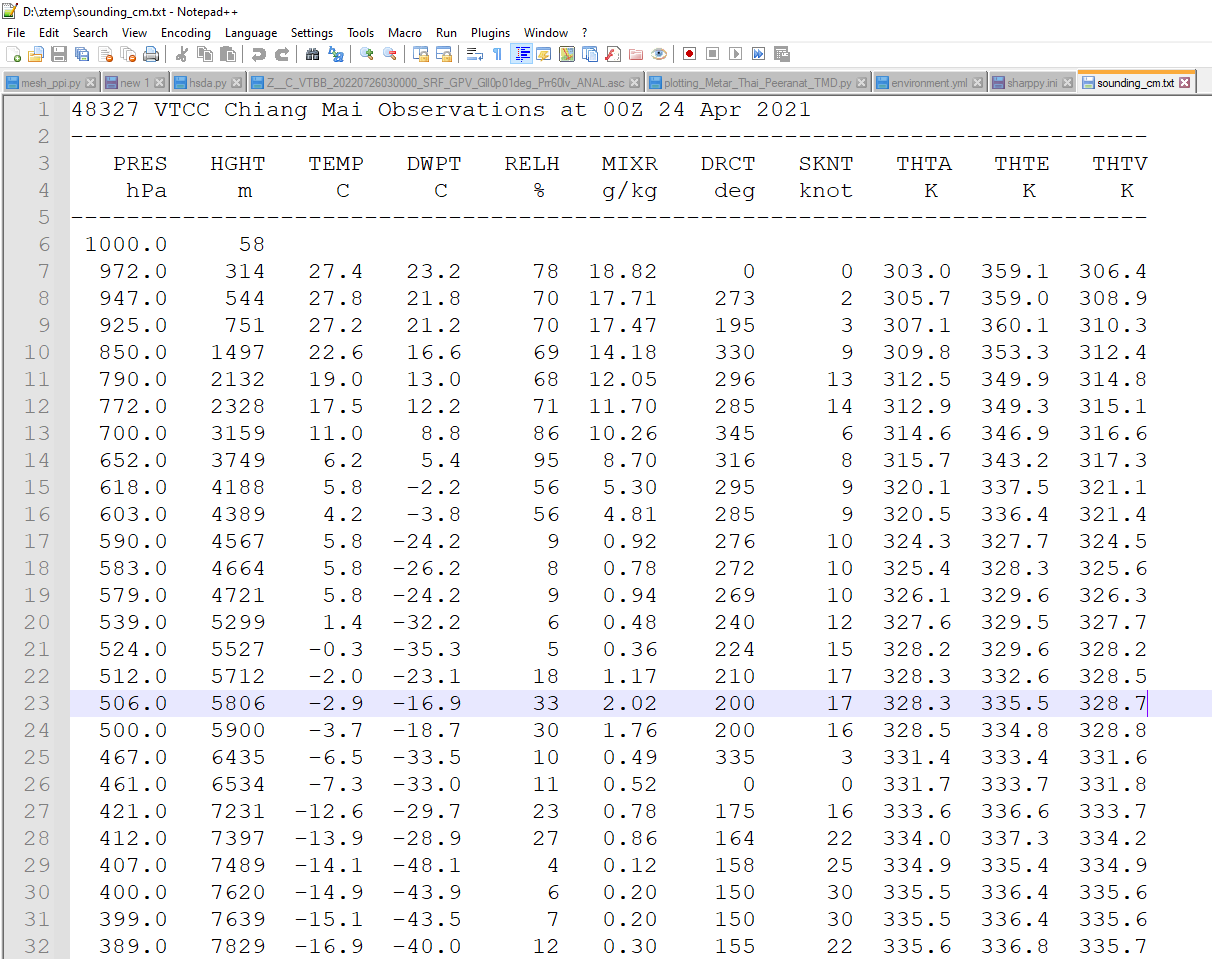

# การคำนวณค่า Potential Temperature ด้วย metpy
* ลิงก์ metpy https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_temperature.html
* ความหมายของ potential temperture https://glossary.ametsoc.org/wiki/Potential_temperature
* อธิบายอุณหภูมิโลกด้วย potential temperature https://scienceofdoom.com/2012/02/12/potential-temperature/
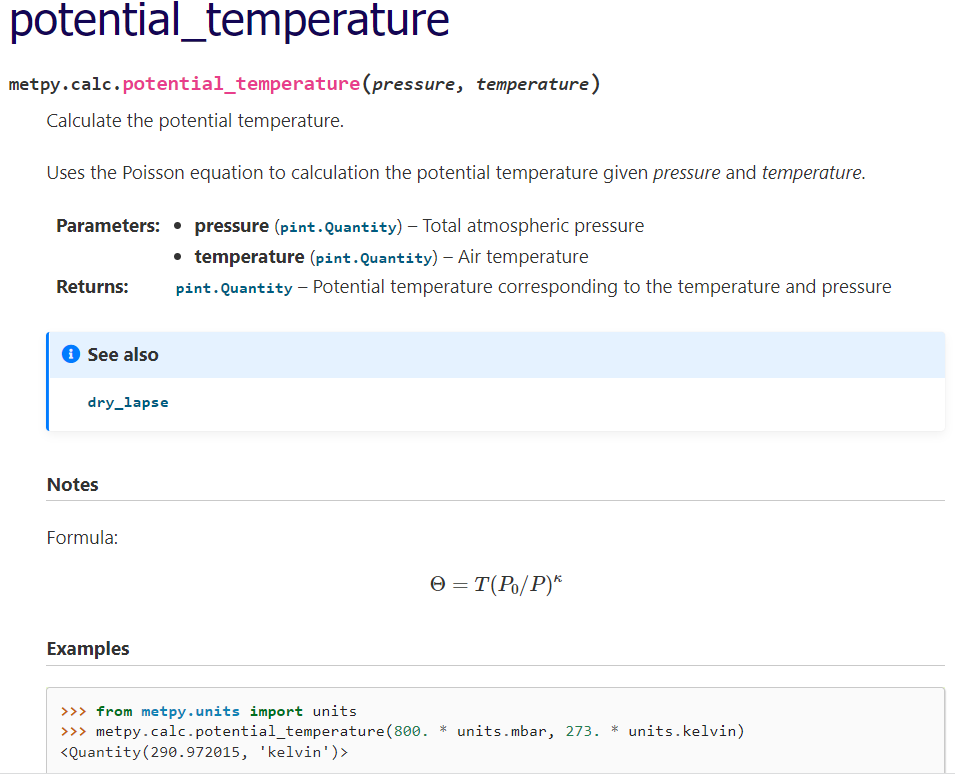


# การคำนวณค่า equivalent Potential Temperature ด้วย metpy
* ลิงก์คำนวณค่า equivalent Potential Temperature ด้วย metpy https://unidata.github.io/MetPy/dev/examples/calculations/Equivalent_Potential_Temperature.html
* ความหมายของ equivalent Potential Temperature https://glossary.ametsoc.org/wiki/Equivalent_potential_temperature
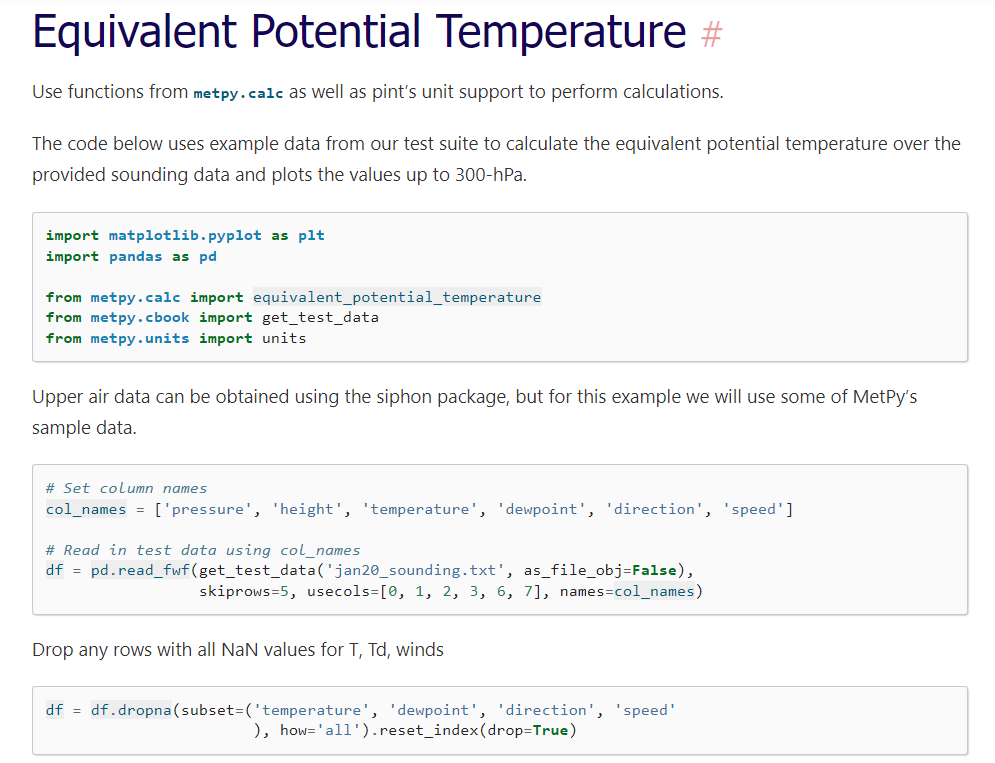

# การคำนวณค่า Virtual Temperature ด้วย metpy
* ลิงก์การคำนวณด้วย metpy https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.virtual_temperature.html#
* ลิงก์ความหมาย https://glossary.ametsoc.org/wiki/Virtual_potential_temperature

สอนการคำนวณในยูทูป
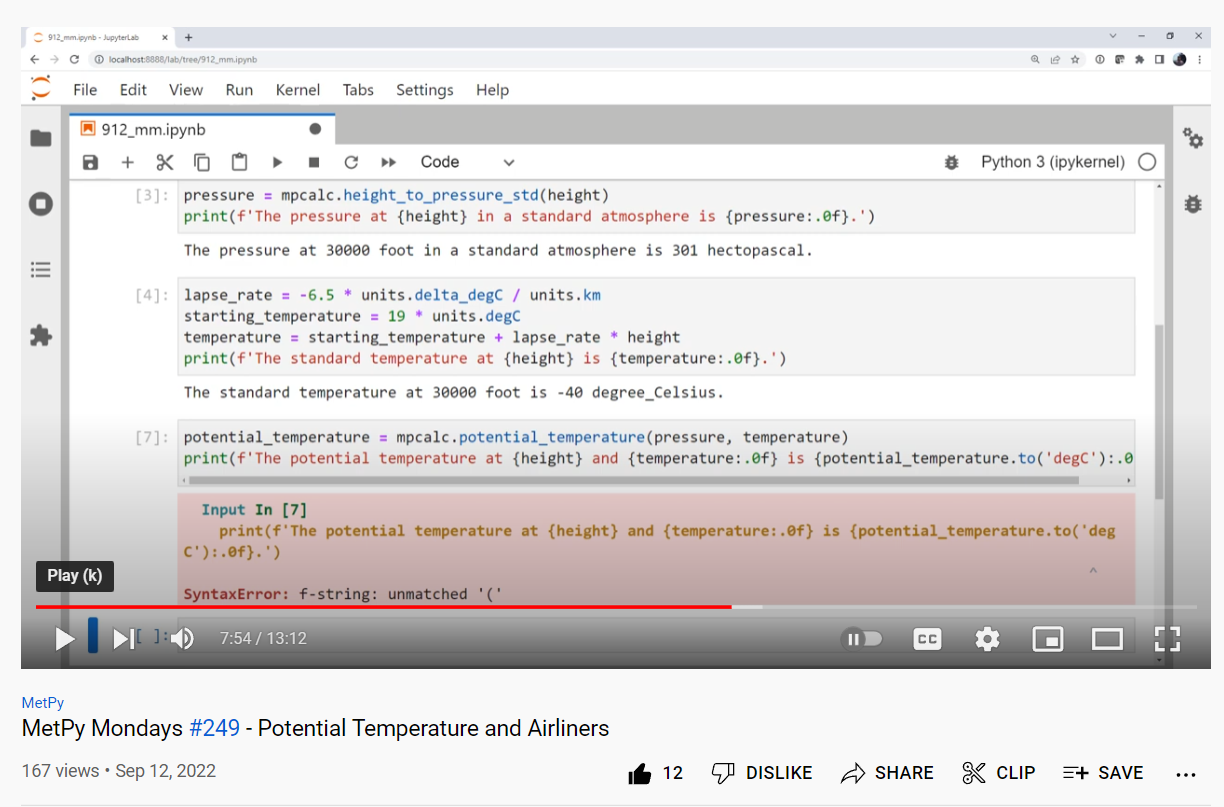